In [1]:
!pip install -q torch_snippets
!pip install -q torch_summary
from torch_snippets import *
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision.datasets import MNIST
import torchvision.transforms as T

tfms = T.Compose([
                  T.ToTensor(),
                  T.Normalize(mean=[0.5],
                              std=[0.5])
])

data = MNIST('/content/',train=True,download=True,transform=tfms)
dl = DataLoader(data,batch_size=128,shuffle=True,drop_last=True)

     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 11.1 MB 32.5 MB/s 
     |████████████████████████████████| 948 kB 54.3 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 59 kB 2.6 MB/s 
     |████████████████████████████████| 232 kB 64.6 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



# **Discriminator**

In [2]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(28*28,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  
  def forward(self,x):
    return self.model(x)

In [3]:
discriminator = Discriminator().to(device)
summary(discriminator,input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       803,840
|    └─LeakyReLU: 2-2                    --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       524,800
|    └─LeakyReLU: 2-5                    --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       131,328
|    └─LeakyReLU: 2-8                    --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      257
|    └─Sigmoid: 2-11                     --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       803,840
|    └─LeakyReLU: 2-2                    --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       524,800
|    └─LeakyReLU: 2-5                    --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       131,328
|    └─LeakyReLU: 2-8                    --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      257
|    └─Sigmoid: 2-11                     --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0

# **Generator**

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(100,256),
        nn.LeakyReLU(),
        nn.Linear(256,512),
        nn.LeakyReLU(),
        nn.Linear(512,1024),
        nn.LeakyReLU(),
        nn.Linear(1024,28*28)
    )
  
  def forward(self,x):
    return self.model(x)

In [5]:
generator = Generator().to(device)
summary(generator,input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       25,856
|    └─LeakyReLU: 2-2                    --
|    └─Linear: 2-3                       131,584
|    └─LeakyReLU: 2-4                    --
|    └─Linear: 2-5                       525,312
|    └─LeakyReLU: 2-6                    --
|    └─Linear: 2-7                       803,600
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       25,856
|    └─LeakyReLU: 2-2                    --
|    └─Linear: 2-3                       131,584
|    └─LeakyReLU: 2-4                    --
|    └─Linear: 2-5                       525,312
|    └─LeakyReLU: 2-6                    --
|    └─Linear: 2-7                       803,600
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0

In [6]:
def noise(size):
  noise = torch.randn(size,100)
  return noise.to(device)

# **Method for classification between real and fake images by Discriminator**

In [7]:
def train_discriminator(real,fake):
  d_optimizer.zero_grad()
  # Real Image Classification
  prediction_r = discriminator(real)
  error_real = loss(prediction_r, torch.ones(len(real),1).to(device)) # Discriminator is expected to predict an output of 1 for "real" images
  error_real.backward()

  # Fake Image Classification
  prediction_f = discriminator(fake)
  error_fake = loss(prediction_f,torch.zeros(len(fake),0).to(device)) # Discriminator is expected to predict an output of 0 for "fake" images
  error_fake.backward()

  d_optimizer.step()
  return error_real + error_fake

# **Method for "Faking" Discriminator by Generator**

In [9]:
def train_generator(fake):
  prediction = discriminator(fake)
  error = loss(prediction, torch.ones(len(fake),1).to(device)) # Generator is expected to produce as many realistic images as possible
  error.backward()

  g_optimizer.step()
  g_optimizer.zero_grad()
  return error

# **Define Requisites**

In [10]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

num_epochs = 200
log = Report(num_epochs)

# **Train the model**

In [11]:
for epoch in range(num_epochs):
  N = len(dl)
  for i, (real, _) in enumerate(iter(dl)):

    real_images = real.view(len(real),-1).to(device)
    fake_images = generator(noise(len(real_images))).to(device)
    fake_images = fake_images.detach() # On detaching, a fresh copy of the tensor is created => when error.backward() is called in the "train_discriminator", the tensors associated with the generator are not affected.

    d_loss = train_discriminator(real_images, fake_images)

    fake_images = generator(noise(len(real_images))).to(device)
    g_loss = train_generator(fake_images)

    log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
  log.report_avgs(epoch+1)

EPOCH: 1.000	d_loss: 1.191	g_loss: 2.475	(21.22s - 4223.36s remaining)
EPOCH: 2.000	d_loss: 1.319	g_loss: 1.065	(38.14s - 3776.07s remaining)
EPOCH: 3.000	d_loss: 0.987	g_loss: 1.302	(51.50s - 3381.60s remaining)
EPOCH: 4.000	d_loss: 0.685	g_loss: 2.273	(66.12s - 3239.79s remaining)
EPOCH: 5.000	d_loss: 0.428	g_loss: 3.376	(81.05s - 3160.97s remaining)
EPOCH: 6.000	d_loss: 0.457	g_loss: 4.004	(94.88s - 3067.65s remaining)
EPOCH: 7.000	d_loss: 0.401	g_loss: 3.589	(107.72s - 2969.96s remaining)
EPOCH: 8.000	d_loss: 0.515	g_loss: 3.189	(123.82s - 2971.59s remaining)
EPOCH: 9.000	d_loss: 0.454	g_loss: 3.361	(137.41s - 2916.23s remaining)
EPOCH: 10.000	d_loss: 0.401	g_loss: 3.320	(150.49s - 2859.40s remaining)
EPOCH: 11.000	d_loss: 0.401	g_loss: 3.343	(165.61s - 2845.49s remaining)
EPOCH: 12.000	d_loss: 0.420	g_loss: 3.354	(180.40s - 2826.19s remaining)
EPOCH: 13.000	d_loss: 0.463	g_loss: 3.165	(195.02s - 2805.25s remaining)
EPOCH: 14.000	d_loss: 0.536	g_loss: 3.028	(215.88s - 2868.08s rema

# **Results**

100%|██████████| 301/301 [00:10<00:00, 28.50it/s]


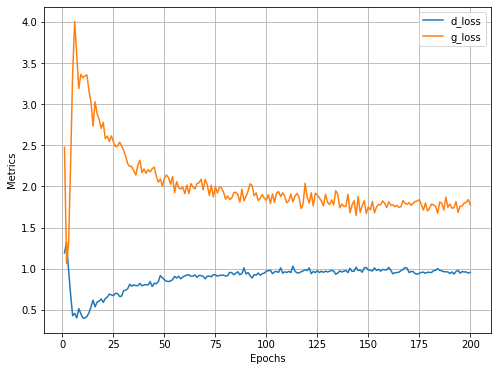

In [12]:
log.plot_epochs(['d_loss','g_loss'])

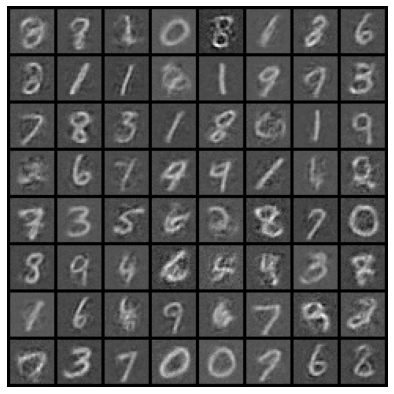

In [15]:
from torchvision.utils import make_grid
NOISE = torch.randn(64,100).to(device)
g_images = generator(NOISE).data.cpu().view(64,1,28,28)
grid = make_grid(g_images,nrow=8,ncol=8,normalize=True)
show(grid.cpu().detach().permute(1,2,0),sz=7)